In [66]:
import knn_mi_comp as kmc
import dynamical_systems_routines as dsr
import dmd_routines as dmd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.linalg as sci
from copy import copy
%matplotlib inline

In [67]:
plt.rcParams.update({ "text.usetex": True, "font.family": "serif" })
font = {'size': 32}
matplotlib.rc('font', **font)
fmt = 'pdf'

In [68]:
xbnd = 10.
dt = .01

In [170]:
tf = 23.
ldata = dsr.generate_lorenz63(-xbnd, xbnd, -xbnd, xbnd,-xbnd, xbnd, 100, dt, tf, seed=1973)
data_name = "Lorenz"
skp = int(20./dt)
tftrain = 22.


Generating Lorenz63 system data...: 100%|█████████████████████████| 100/100 [00:05<00:00, 18.04it/s]


In [108]:
tf = 42.
ldata = dsr.generate_rossler(-xbnd, xbnd, -xbnd, xbnd,-xbnd, xbnd, 100, dt, tf, seed=1973)
data_name = "Rossler"
skp = int(25./dt)
tftrain = 40.
#max_lag = 1000

Generating Rossler system data...: 100%|██████████████████████████| 100/100 [00:09<00:00, 10.52it/s]


In [171]:
nsteps = int(tf/dt) + 1

trainstps = int(tftrain/dt)+1
fullstps = nsteps - skp
tfull = np.linspace(0,tf,nsteps)
training = np.squeeze(ldata[10, :, skp:trainstps])
testing = np.squeeze(ldata[10, :, skp:])
tskp = tfull[skp:]

In [ ]:
ldata0 = np.squeeze(ldata[0, :, :])
xvals = ldata0[0, :].reshape(-1,1)
yvals = ldata0[1, :].reshape(-1,1)
zvals = ldata0[2, :].reshape(-1,1)
i012 = kmc.cmiknn(xvals[1:], yvals[:-1], zvals[:-1], 3)

In [ ]:
print(i012)

In [ ]:
#edist = kmc.shuffle_test(xvals[1:], yvals[:-1], zvals[:-1], 3)
#ax = plt.subplot()
#edist.cdf.plot(ax)
#print(edist.cdf.evaluate(i012))

In [ ]:
#tstpsback = int(0./dt)
#training = tseries[:, :-tstpsback]

#pdim = training.shape[0]
#for jj in range(pdim):
#    avg = np.mean(training[jj, :])
#    sig = np.sqrt(np.mean( (training[jj, :] - avg)**2. ))
#    training[jj, :] = (training[jj, :] - avg)/sig

#test = tseries[:, -tstpsback:]
#print(np.shape(training))
#tmean = np.mean(training, 1)
#training = training - np.tile(np.mean(training, 1).reshape(-1, 1), training.shape[1])

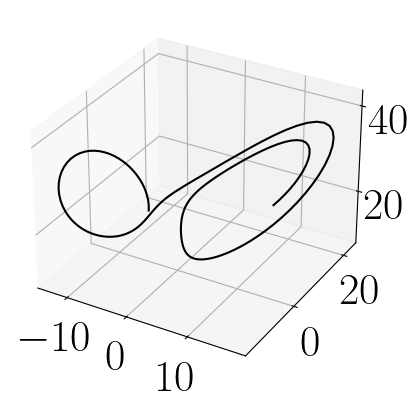

In [172]:
ax = plt.axes(projection='3d')
ax.plot3D(training[0, :], training[1, :], training[2, :], 'black')

In [173]:
u, s, vh = np.linalg.svd(training, full_matrices=False)
print(s)
#training = u.T @ training
#treduced = training[:-1, :]
#ax = plt.axes(projection='3d')
#ax.plot3D(training[0, :], training[1, :], training[2, :], 'black')

[367.71057061 167.68014583  42.97487032]


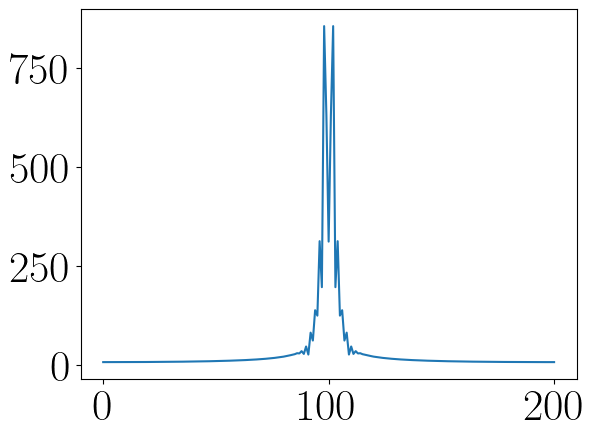

In [174]:
plt.plot(np.fft.fftshift(np.abs(np.fft.fft(training[0,:]))))

In [187]:
max_lag = 100

chosen_kmats, chosen_lags = dmd.it_dmd(max_lag, training)
ed_model = dmd.lagged_model_cmp(training, chosen_kmats, chosen_lags, max_lag, fullstps)

print("Final lag choices are:")
print(chosen_lags)

Current choices for lags are:
[1, 15, 26, 35, 45, 48, 68, 73, 97, 99]
Final lag choices are:
[1, 15, 26, 35, 45, 48, 68, 73, 97, 99]


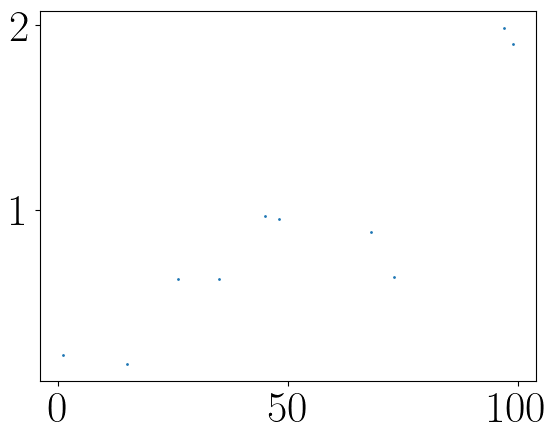

In [188]:
knorms_chosen = np.zeros(len(chosen_lags))
for kk in range(len(chosen_lags)):
    knorms_chosen[kk] = np.linalg.norm(chosen_kmats[:, kk*pdim:(kk+1)*pdim], 'fro')
klog_chosen = np.log10(knorms_chosen)[::-1]
chosen_inds = [val-1 for val in chosen_lags]
plt.scatter(chosen_lags, klog_chosen, s=1.)

In [189]:
pdim = 3
kfin = chosen_kmats[:, :pdim]
k1 = chosen_kmats[:, -pdim:]
print(kfin)

[[ 3.27235233e+00  3.81839184e-01  4.14674354e-02]
 [ 6.94062907e+01  8.29621530e+00  9.11353145e-01]
 [-3.67798309e+01 -5.91357640e+00  2.20933771e-01]]


In [180]:
# Lorenz, lag = 150 slow scale eigenvalue decompositions
k149i = np.linalg.solve(-k1,kfin)
evals_inner, evecs_inner = np.linalg.eig(k149i)
tot_evals_inner = np.zeros(148*pdim,dtype=np.complex128)
rvals = np.abs(evals_inner)**(1./148.)
angs = np.angle(evals_inner)
for jj in range(148):
    tot_evals_inner[jj*pdim:(jj+1)*pdim] = rvals * np.exp(1j * ( angs/148 + 2.*np.pi*jj/148 ))

In [190]:
# Lorenz, lag = 100 slow scale eigenvalue decompositions
kpenu = chosen_kmats[:, pdim:2*pdim]
k99i = np.linalg.solve(-kpenu,kfin)
evals_inner, evecs_inner = np.linalg.eig(k99i)
rvals = np.abs(evals_inner)**(1./2.)
inds_kp = rvals < 1.
tot_inds = np.sum(inds_kp)
tot_evals_inner = np.zeros(2*tot_inds,dtype=np.complex128)

angs = np.angle(evals_inner[inds_kp])
for jj in range(2):
    tot_evals_inner[jj*tot_inds:(jj+1)*tot_inds] = rvals[inds_kp] * np.exp(1j * ( angs/2. + 2.*np.pi*jj/2.))

In [144]:
# Rossler, lag = 1000 slow scale eigenvalue decomposition
kfinm1 = chosen_kmats[:, pdim:2*pdim]
k323i = np.linalg.solve(-kfinm1,kfin)
evals_inner, evecs_inner = np.linalg.eig(k323i)
rvals = np.abs(evals_inner)**(1./323.)
rvals_kp = rvals < .99
totvals = np.sum(rvals_kp)
tot_evals_inner = np.zeros(323*totvals,dtype=np.complex128)

angs = np.angle(evals_inner)
for jj in range(323):
    tot_evals_inner[jj*totvals:(jj+1)*totvals] = rvals[rvals_kp] * np.exp(1j * ( angs[rvals_kp]/323 + 2.*np.pi*jj/323 ))

In [137]:
chosen_kmats_inner = chosen_kmats[:, -2*pdim:]
chosen_lags_inner = chosen_lags[-2:]
tot_evals_inner, tot_evecs_inner = dmd.evals_computer(chosen_kmats_inner, chosen_lags_inner)

In [138]:
# Rossler, lag = 1000 slow scale eigenvalue decomposition
k3 = chosen_kmats[:, -2*pdim:-pdim]
compmat = np.zeros((3*pdim, 3*pdim), dtype=np.complex128)
imat = np.eye(pdim)
compmat[:pdim, pdim:2*pdim] = imat
compmat[pdim:2*pdim, 2*pdim:3*pdim] = imat
compmat[2*pdim:3*pdim, :pdim] = k3
compmat[2*pdim:3*pdim, -pdim:] = k1
evals_outer, evecs_outer = np.linalg.eig(compmat)
rvals_outer = np.abs(evals_outer) 
rvals_outer_kp = rvals_outer > 1
tot_evals_outer = evals_outer[rvals_outer_kp]

In [139]:
#evals_outer, evecs_outer = np.linalg.eig(k1)

In [191]:
evals, evecs = dmd.evals_computer(chosen_kmats, chosen_lags)

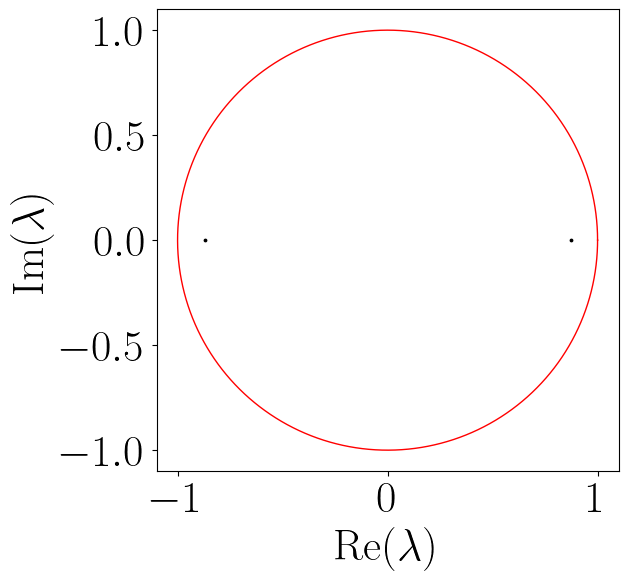

In [192]:
theta_vals = np.linspace(0., 2.*np.pi, 1000)

fig = plt.figure(figsize=(9, 6))
plt.scatter(tot_evals_inner.real, tot_evals_inner.imag, s=3., c='k')
plt.plot(np.cos(theta_vals), np.sin(theta_vals),c='r',linewidth=1.)
plt.xlabel(r"$\mbox{Re}(\lambda)$")
plt.ylabel(r"$\mbox{Im}(\lambda)$")
plt.gca().set_aspect('equal')
plt.savefig(data_name+f"_reduced_spectrum_w_mx_lag_{str(chosen_lags[-1])}."+"pdf",bbox_inches='tight',format="pdf")

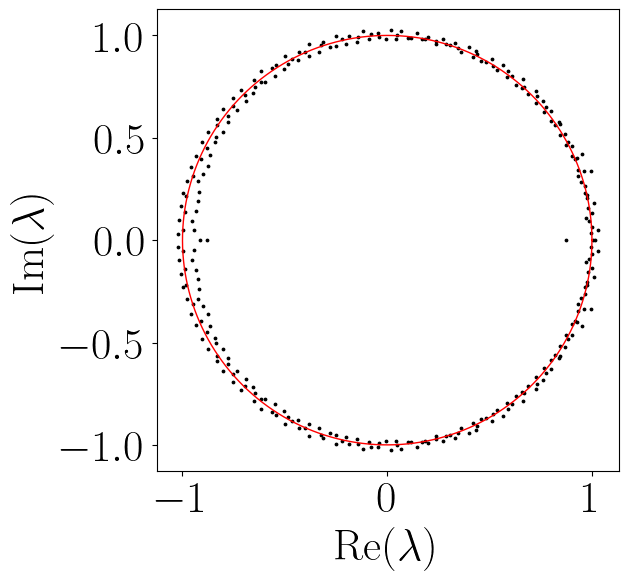

In [193]:
theta_vals = np.linspace(0., 2.*np.pi, 1000)

fig = plt.figure(figsize=(9, 6))
plt.scatter(evals.real, evals.imag, s=3., c='k')
plt.plot(np.cos(theta_vals), np.sin(theta_vals),c='r',linewidth=1.)
plt.xlabel(r"$\mbox{Re}(\lambda)$")
plt.ylabel(r"$\mbox{Im}(\lambda)$")
plt.gca().set_aspect('equal')
plt.savefig(data_name+f"_spectrum_w_mx_lag_{str(chosen_lags[-1])}."+"pdf",bbox_inches='tight',format="pdf")

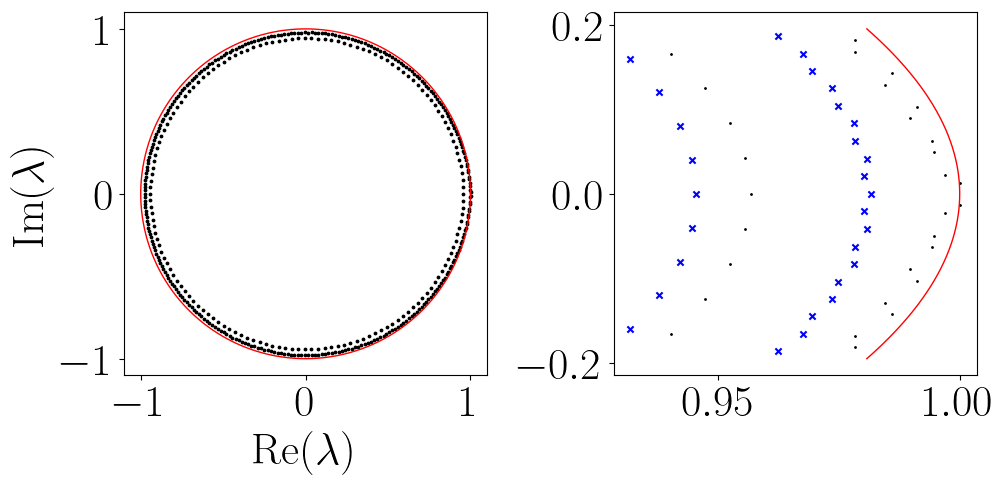

In [184]:
aptr = np.pi/16.

inds_kp = np.abs(np.angle(evals)) < aptr
inds_kpr = np.abs(np.angle(tot_evals_inner)) < aptr
#inds_kpo = np.abs(np.angle(tot_evals_outer)) < aptr
theta_vals = np.linspace(0., 2.*np.pi, 1000)

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(evals.real, evals.imag, s=3., c='k')
ax.plot(np.cos(theta_vals), np.sin(theta_vals),c='r',linewidth=1.)
ax.set_xlabel(r"$\mbox{Re}(\lambda)$")
ax.set_ylabel(r"$\mbox{Im}(\lambda)$")
ax.set_box_aspect(1.)
theta_vals = np.linspace(-aptr, aptr, 1000)

ax = fig.add_subplot(1, 2, 2)
ax.scatter(evals[inds_kp].real, evals[inds_kp].imag, s=1., c='k')
ax.scatter(tot_evals_inner[inds_kpr].real, tot_evals_inner[inds_kpr].imag, s=20., c='b', marker='x')
#ax.scatter(tot_evals_outer[inds_kpo].real, tot_evals_outer[inds_kpo].imag, s=20., c='g', marker='x')
ax.plot(np.cos(theta_vals), np.sin(theta_vals),c='r',linewidth=1.)
ax.set_xticks([.95, 1.])
ax.set_yticks([-.2, 0., .2])
ax.set_box_aspect(1.)

plt.subplots_adjust(left=None, bottom=None, right=.9, top=None, wspace=.35, hspace=None)
#plt.gca().set_aspect('equal')
plt.savefig(data_name+f"_detail_spectrum_w_mx_lag_{str(chosen_lags[-1])}."+"pdf",bbox_inches='tight',format="pdf")

In [194]:
max_all_lag = max_lag
all_lags = list(np.arange(1, max_all_lag))

all_kmats = dmd.lagged_dmd_cmp(training, all_lags)
all_model = dmd.lagged_model_cmp(training, all_kmats, all_lags, max_all_lag, fullstps)

knorms_all = np.zeros(max_lag-1)
for jj in range(max_lag-1):
    knorms_all[jj] = np.linalg.norm(all_kmats[:, jj*pdim:(jj+1)*pdim], 'fro')
klog_all = np.log10(knorms_all)[::-1]

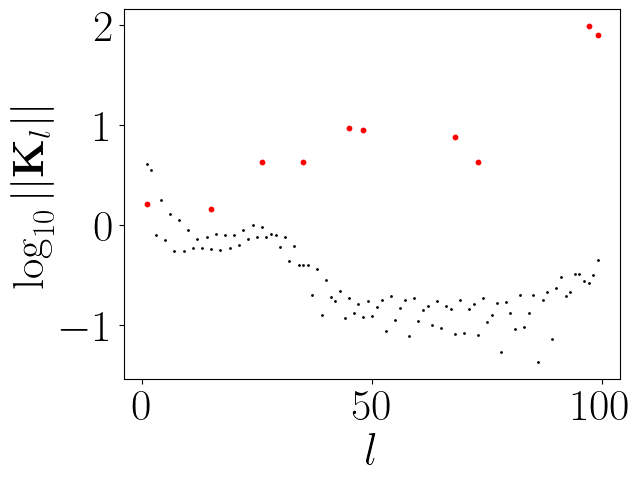

In [195]:
plt.scatter(np.arange(1, max_lag), klog_all,color='k',s=1.)
plt.scatter(chosen_lags, klog_chosen,color='r',s=10.)
plt.xlabel(r"$l$")
plt.ylabel(r"$\log_{10}||{\bf K}_{l}||$")
plt.savefig(data_name+f"_norm_full_model_{str(chosen_lags[-1])}."+"pdf",bbox_inches='tight',format="pdf")

In [ ]:
#thorizon = chosen_lags[-1] + 190
#thorizon = chosen_lags[-1] + 100

fig = plt.figure(figsize=(12, 8))
axis_labels=[r'$y_{1}$', r'$y_{2}$', r'$y_{3}$']
for dim in range(3):
    ax = fig.add_subplot(3, 1, dim+1)
    ax.plot(tskp, ed_model[dim, :], c='k')
    ax.plot(tskp, all_model[dim, :], c='r')
    ax.plot(tskp, testing[dim, :], c='b', ls='--')
    
    ax.plot([tskp[chosen_lags[-1]], tskp[chosen_lags[-1]]], [np.min(ed_model[dim, :]), np.max(ed_model[dim, :])], c='k')
    ax.plot([tskp[trainstps-skp], tskp[trainstps-skp]], [np.min(ed_model[dim, :]), np.max(ed_model[dim, :])], c='k', ls='--')

    ax.set_ylabel(axis_labels[dim])
    
fig.tight_layout(pad=1.0)
plt.savefig(data_name+f"_compare_w_mx_lag_{str(max_all_lag)}."+"pdf",bbox_inches='tight',format="pdf")

In [ ]:
thorizon = chosen_lags[-1] + 1000

fig = plt.figure(figsize=(12, 8))
axis_labels=[r'$y_{1}$', r'$y_{2}$', r'$y_{3}$']
for dim in range(3):
    ax = fig.add_subplot(3, 1, dim+1)
    
    ed_dif = np.ma.log10(np.abs(ed_model[dim, :thorizon]-testing[dim, :thorizon]))
    all_dif = np.ma.log10(np.abs(all_model[dim, :thorizon]-testing[dim, :thorizon]))
    
    ax.plot(tskp[:thorizon], ed_dif, c='k')
    ax.plot(tskp[:thorizon], all_dif, c='r')
    
    ax.plot([tskp[chosen_lags[-1]], tskp[chosen_lags[-1]]], [np.min(all_dif), np.max(ed_dif)], c='k')
    ax.plot([tskp[trainstps-skp], tskp[trainstps-skp]], [np.min(all_dif), np.max(ed_dif)], c='k', ls='--')

    ax.set_ylabel(axis_labels[dim])
    
fig.tight_layout(pad=1.0)
plt.savefig(data_name+f"_error_compare_w_mx_lag_{str(max_all_lag)}."+"pdf",bbox_inches='tight',format="pdf")